In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!tar -xvf /content/drive/My\ Drive/yelp_dataset.tar

business.json
checkin.json
review.json
tip.json
user.json
photo.json
Dataset_Challenge_Dataset_Agreement.pdf
Yelp_Dataset_Challenge_Round_13.pdf


In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import time
start_time=time.time()
import folium
import folium.plugins as plugins
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%pylab inline
import requests, re
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud

Populating the interactive namespace from numpy and matplotlib


In [0]:
business = pd.read_json('business.json',lines=True)

In [4]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


In [5]:
business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [6]:
business['is_open'].value_counts()

1    158525
0     34084
Name: is_open, dtype: int64

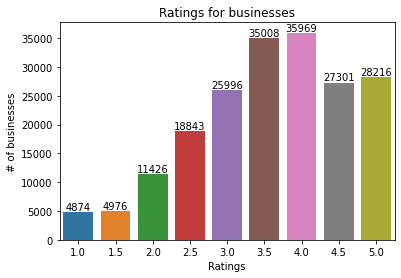

In [7]:
x = business['stars'].value_counts()
x=x.sort_index()

ax= sns.barplot(x=x.index, y=x.values)
plt.title("Ratings for businesses")
plt.xlabel('Ratings')
plt.ylabel('# of businesses')

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
  
plt.show()

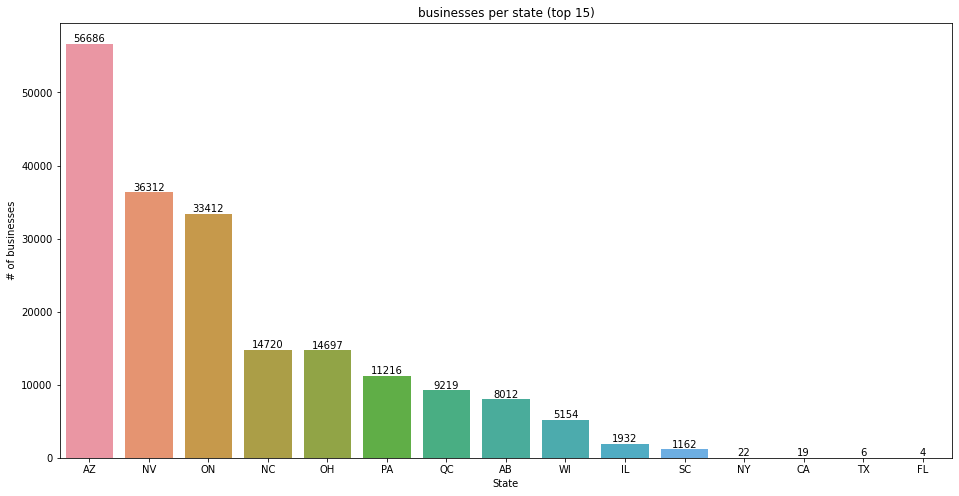

In [8]:
x = business['state'].value_counts()
x=x.sort_values(ascending=False).head(15)

plt.figure(figsize=(16,8))

ax= sns.barplot(x=x.index, y=x.values)
plt.title("businesses per state (top 15)")
plt.xlabel('State')
plt.ylabel('# of businesses')

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
  
plt.show()

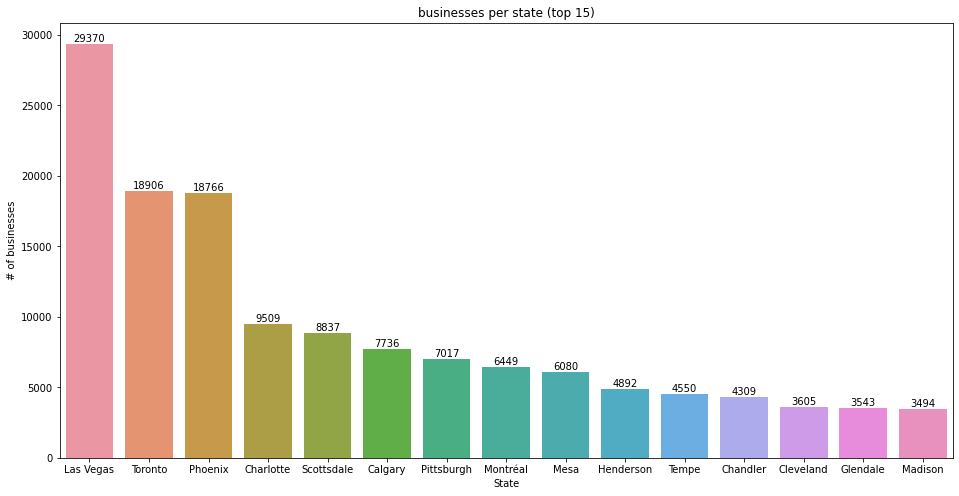

In [9]:
x = business['city'].value_counts()
x=x.sort_values(ascending=False).head(15)

plt.figure(figsize=(16,8))

ax= sns.barplot(x=x.index, y=x.values)
plt.title("businesses per state (top 15)")
plt.xlabel('State')
plt.ylabel('# of businesses')

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
  
plt.show()

In [0]:
business_cats=','.join(map(str,business['categories']))

cats=pd.DataFrame(business_cats.split(','),columns=['category'])

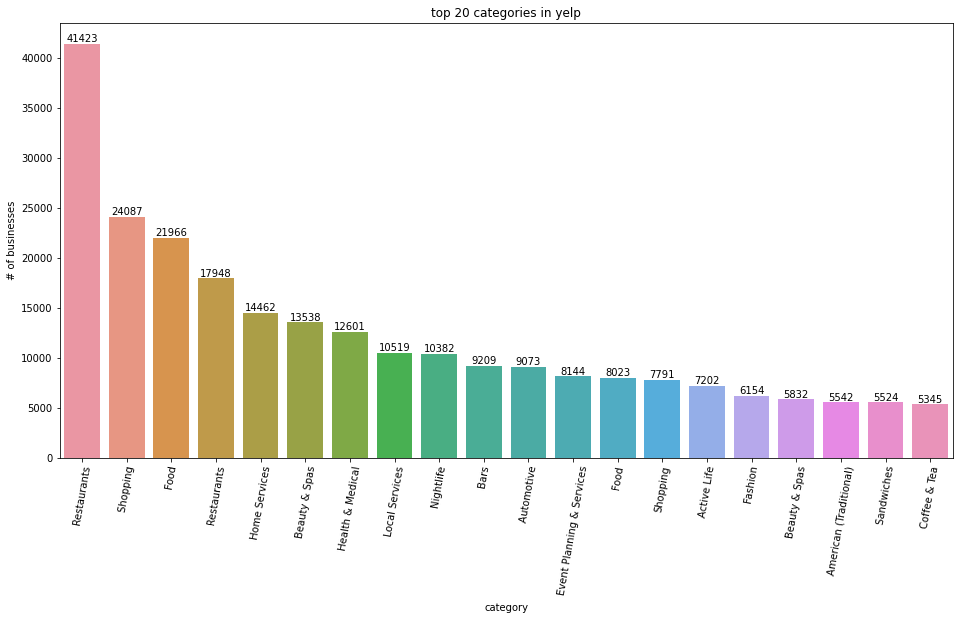

In [11]:
x = cats['category'].value_counts()
x=x.sort_values(ascending=False).head(20)

plt.figure(figsize=(16,8))

ax= sns.barplot(x=x.index, y=x.values)
plt.title("top 20 categories in yelp")
plt.xlabel('category')
plt.ylabel('# of businesses')
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
  
plt.show()

In [0]:
## remove quotation marks in name and address column
business.name=business.name.str.replace('"','')
business.address=business.address.str.replace('"','')

## filter restaurants of US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]

In [13]:
usa['categories'].str.contains('Restaurants')

0         False
2          True
3         False
4         False
7         False
          ...  
192603     True
192604    False
192606    False
192607    False
192608    False
Name: categories, Length: 141954, dtype: object

In [0]:
## select all restaurants in USA
us_restaurants=usa[usa['categories'].str.contains('Restaurants', na=False)]

## select out 16 cuisine types of restaurants and rename the category
us_restaurants.is_copy=False
us_restaurants['category']=pd.Series()
us_restaurants.loc[us_restaurants.categories.str.contains('American'),'category'] = 'American'
us_restaurants.loc[us_restaurants.categories.str.contains('Mexican'), 'category'] = 'Mexican'
us_restaurants.loc[us_restaurants.categories.str.contains('Italian'), 'category'] = 'Italian'
us_restaurants.loc[us_restaurants.categories.str.contains('Japanese'), 'category'] = 'Japanese'
us_restaurants.loc[us_restaurants.categories.str.contains('Chinese'), 'category'] = 'Chinese'
us_restaurants.loc[us_restaurants.categories.str.contains('Thai'), 'category'] = 'Thai'
us_restaurants.loc[us_restaurants.categories.str.contains('Mediterranean'), 'category'] = 'Mediterranean'
us_restaurants.loc[us_restaurants.categories.str.contains('French'), 'category'] = 'French'
us_restaurants.loc[us_restaurants.categories.str.contains('Vietnamese'), 'category'] = 'Vietnamese'
us_restaurants.loc[us_restaurants.categories.str.contains('Greek'),'category'] = 'Greek'
us_restaurants.loc[us_restaurants.categories.str.contains('Indian'),'category'] = 'Indian'
us_restaurants.loc[us_restaurants.categories.str.contains('Korean'),'category'] = 'Korean'
us_restaurants.loc[us_restaurants.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
us_restaurants.loc[us_restaurants.categories.str.contains('African'),'category'] = 'African'
us_restaurants.loc[us_restaurants.categories.str.contains('Spanish'),'category'] = 'Spanish'
us_restaurants.loc[us_restaurants.categories.str.contains('Middle_eastern'),'category'] = 'Middle_eastern'

In [15]:
## drop null values in category, delete original column categories and reset the index
us_restaurants=us_restaurants.dropna(axis=0, subset=['category'])
del us_restaurants['categories']
us_restaurants=us_restaurants.reset_index(drop=True)
us_restaurants.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,hours,category
0,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",Japanese
1,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Phoenix,AZ,85016,33.495194,-112.028588,3.0,18,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W...",Mexican
2,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Mentor-on-the-Lake,OH,44060,41.708520,-81.359556,4.0,16,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ...",Italian
3,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128529,4.0,40,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...",None,Italian
4,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,6055 E Lake Mead Blvd,Las Vegas,NV,89156,36.195615,-115.040529,4.5,184,1,"{'BikeParking': 'True', 'BusinessParking': '{'...","{'Monday': '11:0-21:0', 'Tuesday': '10:0-21:0'...",Mexican
5,BvYU3jvGd0TJ7IyZdfiN2Q,Manzetti's Tavern,6401 Morrison Blvd,Charlotte,NC,28211,35.156338,-80.831878,3.5,16,0,"{'Alcohol': 'u'full_bar'', 'BusinessAcceptsCre...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",Italian
6,v-scZMU6jhnmV955RSzGJw,No. 1 Sushi Sushi,436 Market St,Pittsburgh,PA,15222,40.441062,-80.002126,4.5,106,1,"{'OutdoorSeating': 'False', 'HasTV': 'True', '...","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",Japanese
7,KFbUQ-RR2UOV62Ep7WnXHw,Westwood Bar & Grill,825 Commonwealth Ave,West Mifflin,PA,15122,40.376674,-79.882480,3.0,5,1,"{'GoodForMeal': '{'dessert': False, 'latenight...","{'Wednesday': '11:0-0:0', 'Thursday': '11:0-0:...",American
8,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,"13843 N Tatum Blvd, Ste 15",Phoenix,AZ,85032,33.613020,-111.977036,3.5,269,1,"{'Caters': 'True', 'GoodForKids': 'True', 'Noi...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",Chinese
9,X8mtoSxY8whtmbDlj0D3Aw,Imperial Asian Buffet,4343 N Rancho Dr,Las Vegas,NV,89030,36.238596,-115.233331,2.0,4,1,None,None,Chinese


In [16]:
## check total number of us restaurants
us_restaurants.shape

(21160, 14)

In [17]:
## check whether has duplicated business id
us_restaurants.business_id.duplicated().sum()

0

In [18]:
## check the datatype
us_restaurants.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
hours            object
category         object
dtype: object

In [19]:
## check missing values
us_restaurants.isnull().sum()

business_id        0
name               0
address            0
city               0
state              0
postal_code        0
latitude           0
longitude          0
stars              0
review_count       0
is_open            0
attributes       493
hours           3935
category           0
dtype: int64

In [0]:
review = pd.read_json('review.json',lines=True,chunksize=1000000)

In [0]:
review_csv = pd.DataFrame()

In [0]:
for record in review:
    review_csv = review_csv.append(pd.DataFrame(record))

In [23]:
review_csv.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


In [24]:
## check missing values
review_csv.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [25]:
## check duplicates of review_id
review_csv.review_id.duplicated().sum()

0

In [0]:
## merge business table and review table
restaurants_reviews = pd.merge(us_restaurants, review_csv, on = 'business_id')

## update column names
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)

## add column of number of words in review and label of negative and postive reviews
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))

In [27]:
# label reviews as positive or negative
restaurants_reviews['labels'] = ''
restaurants_reviews.loc[restaurants_reviews.review_star >=4, 'labels'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.review_star ==3, 'labels'] = 'neural'
restaurants_reviews.loc[restaurants_reviews.review_star <3, 'labels'] = 'negative'

# drop neutral reviews for easy analysis
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] =='neural'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)

restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,attributes,hours,category,review_id,user_id,review_star,useful,funny,cool,text,date,num_words_review,labels
0,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",Japanese,F7POrJsNbhu493DSTMPXjw,nsS4oDfOsl20QdWc6XcOkw,2,1,0,0,"Husband was craving Chicken Teriyaki & gyoza, ...",2014-02-24 02:51:56,76,negative
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",Japanese,c-6aA9Bd7JxpmMroRoas9A,bK4Y_GZUoAUTXIrmeEUGYw,4,0,0,1,Went there Saturday noon they open at 12pm but...,2014-07-13 20:28:18,34,positive
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",Japanese,P_MV_lMQjLIO9R7M_KIuMg,sbbB6Y4yIZIInvt0LFYYew,2,1,0,0,Went to this restaurant on Saturday as I had a...,2018-05-09 00:39:36,169,negative
3,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",Japanese,dCLBdXP9tjjQG7EkHNeWzQ,hhQUVO2AqBdSeQcPo19Bsw,5,4,2,3,This place will always have a place in my stom...,2017-10-25 13:58:04,272,positive
4,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",Japanese,GiBx0zRVxC1Bu-9R-MMF8w,XSz4svDvgOCRO92V_3ajWg,4,0,0,0,"Well first time I've really had ""authentic"" Ja...",2015-04-02 01:13:36,80,positive


Exploratory Data Analysis

In [0]:
plt.style.use('ggplot')

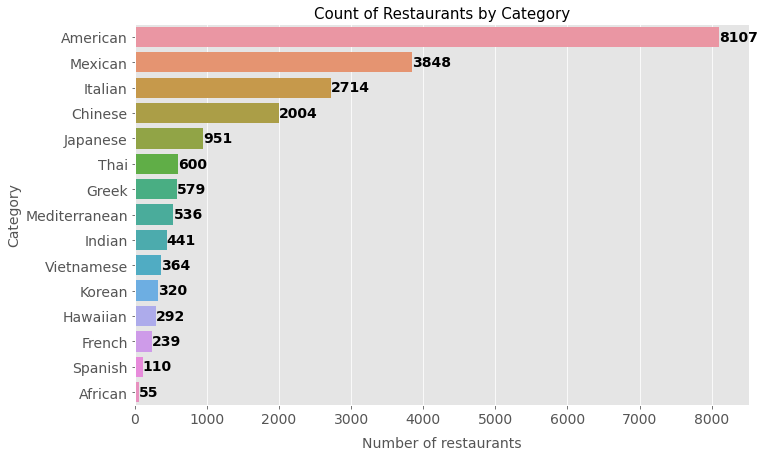

In [29]:
plt.figure(figsize=(11,7))
grouped = us_restaurants.category.value_counts()
sns.countplot(y='category',data=us_restaurants, 
              order = grouped.index)
plt.xlabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Category', fontsize=14)
plt.title('Count of Restaurants by Category', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(us_restaurants.category.value_counts()):
    plt.text(v, i+0.15, str(v), fontweight='bold', fontsize=14)

The top 5 type of restaurants are American, Mexican, Italian, Chinese and Japanese.

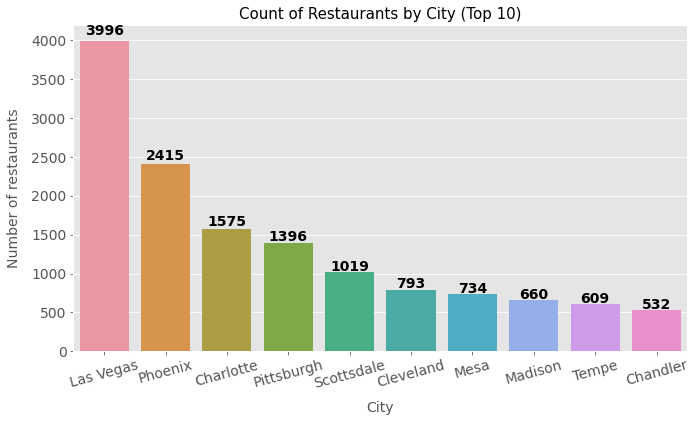

In [30]:
# Top 10 cities with most restaurants

plt.figure(figsize=(11,6))
grouped = us_restaurants.city.value_counts()[:10]
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

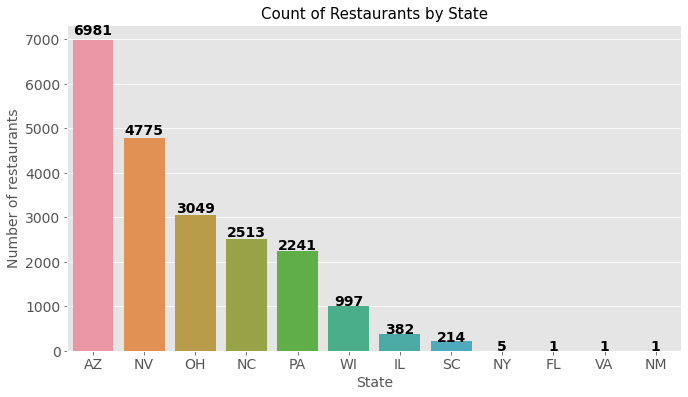

In [31]:
## Distribution of restaurants in each state

plt.figure(figsize=(11,6))
grouped = us_restaurants.state.value_counts()
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of restaurants', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.title('Count of Restaurants by State', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontweight='bold', fontsize=14)

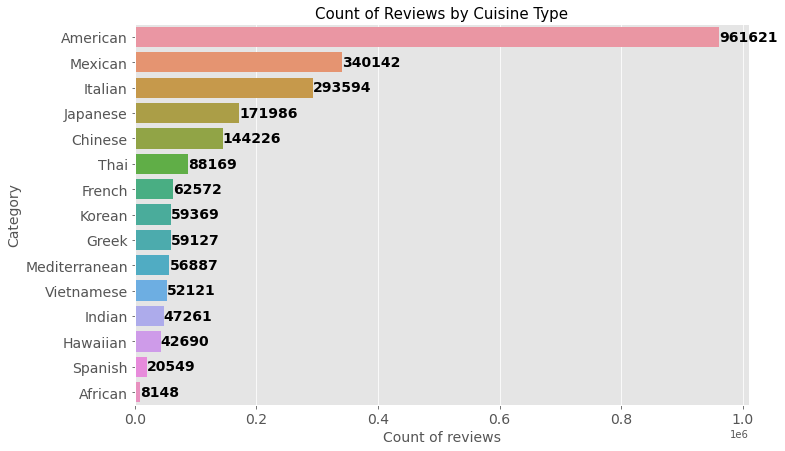

In [32]:
## Distribution of reviews by cuisine type
plt.figure(figsize=(11,7))
grouped = us_restaurants.groupby('category')['review_count'].sum().sort_values(ascending = False)
sns.barplot(y=grouped.index, x= grouped.values)
plt.ylabel('Category', fontsize=14)
plt.xlabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews by Cuisine Type', fontsize=15)
for i,v in enumerate(grouped):
    plt.text(v, i+0.15, str(v),fontweight='bold', fontsize=14)
plt.tick_params(labelsize=14)

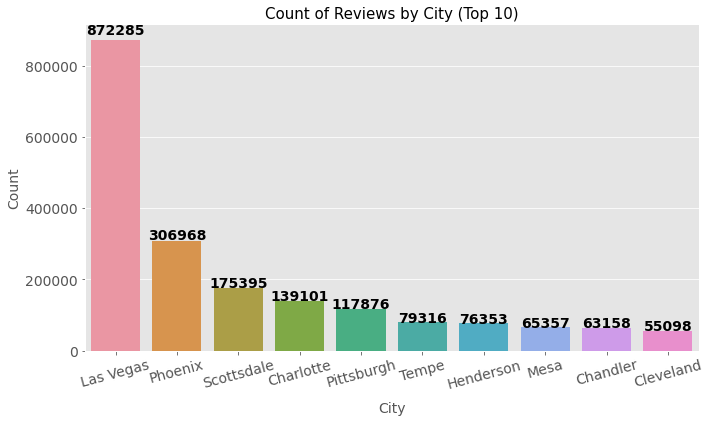

In [33]:
## Top 10 cities with most reviews
plt.figure(figsize=(11,6))
grouped = us_restaurants.groupby('city')['review_count'].sum().sort_values(ascending=False)[:10]
sns.barplot(grouped.index, grouped.values)
plt.xlabel('City', labelpad=10, fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Reviews by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

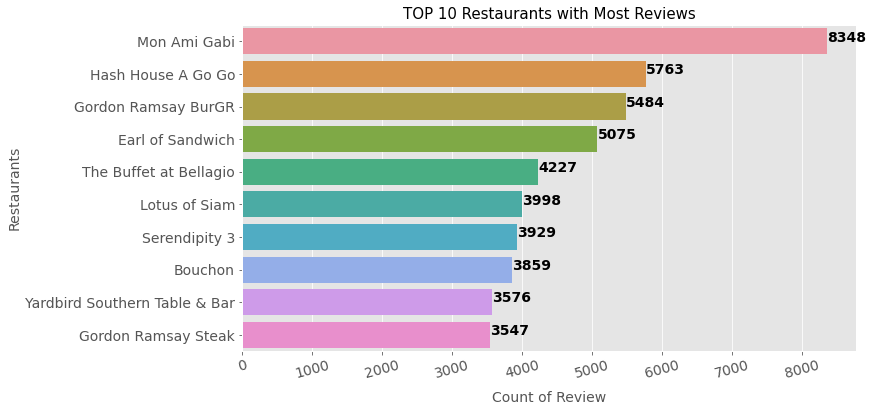

In [34]:
## Top 10 restaurants with most reviews
plt.figure(figsize=(11,6))
grouped = us_restaurants[['name','review_count']].sort_values(by='review_count', ascending=False)[:10]
sns.barplot(x=grouped.review_count, y = grouped.name, ci=None)
plt.xlabel('Count of Review', labelpad=10, fontsize=14)
plt.ylabel('Restaurants', fontsize=14)
plt.title('TOP 10 Restaurants with Most Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped.review_count):
    plt.text(v, i, str(v), fontweight='bold', fontsize=14)

In [35]:
restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,attributes,hours,category,review_id,user_id,review_star,useful,funny,cool,text,date,num_words_review,labels
0,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",Japanese,F7POrJsNbhu493DSTMPXjw,nsS4oDfOsl20QdWc6XcOkw,2,1,0,0,"Husband was craving Chicken Teriyaki & gyoza, ...",2014-02-24 02:51:56,76,negative
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",Japanese,c-6aA9Bd7JxpmMroRoas9A,bK4Y_GZUoAUTXIrmeEUGYw,4,0,0,1,Went there Saturday noon they open at 12pm but...,2014-07-13 20:28:18,34,positive
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",Japanese,P_MV_lMQjLIO9R7M_KIuMg,sbbB6Y4yIZIInvt0LFYYew,2,1,0,0,Went to this restaurant on Saturday as I had a...,2018-05-09 00:39:36,169,negative
3,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",Japanese,dCLBdXP9tjjQG7EkHNeWzQ,hhQUVO2AqBdSeQcPo19Bsw,5,4,2,3,This place will always have a place in my stom...,2017-10-25 13:58:04,272,positive
4,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",Japanese,GiBx0zRVxC1Bu-9R-MMF8w,XSz4svDvgOCRO92V_3ajWg,4,0,0,0,"Well first time I've really had ""authentic"" Ja...",2015-04-02 01:13:36,80,positive


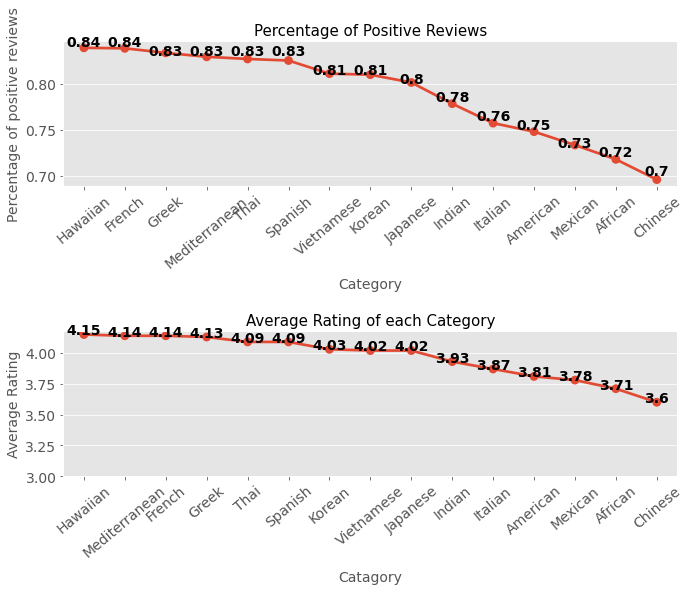

In [36]:
## Distribution of positive and negative reviews in each category

table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)
plt.figure(figsize=(11,8))
plt.subplot(211)
sns.pointplot(x=table_percentage.index, y= table_percentage.values)
plt.xlabel('Category', labelpad=7, fontsize=14)
plt.ylabel('Percentage of positive reviews', fontsize=14)
plt.title('Percentage of Positive Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(table_percentage.round(2)):
    plt.text(i, v*1.001, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplot(212)
grouped = restaurants_reviews.groupby('category')['review_star'].mean().round(2).sort_values(ascending=False)
sns.pointplot(grouped.index, grouped.values)
plt.ylim(3)
plt.xlabel('Catagory', labelpad=10, fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Rating of each Category', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(grouped):
    plt.text(i, v, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplots_adjust(hspace=1)

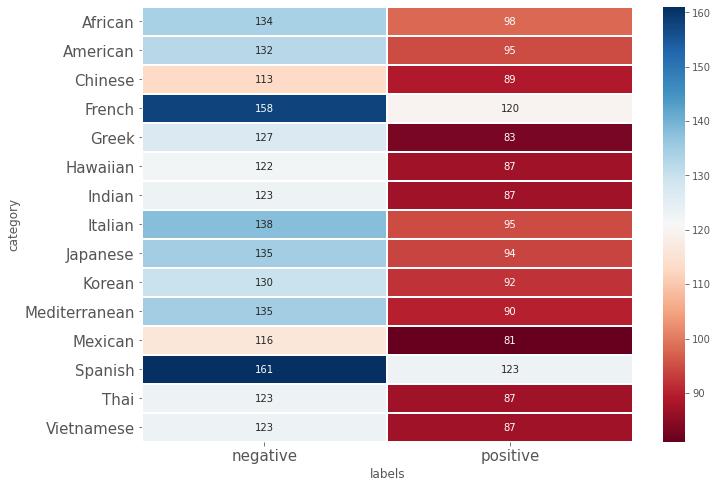

In [37]:
## Average length of reviews in each category

table = restaurants_reviews.groupby(['category','labels'])['num_words_review'].mean().round().unstack()
plt.figure(figsize=(11,8))
sns.heatmap(table, cmap='RdBu',fmt='g',annot=True, linewidths=1)
plt.tick_params(labelsize=15)

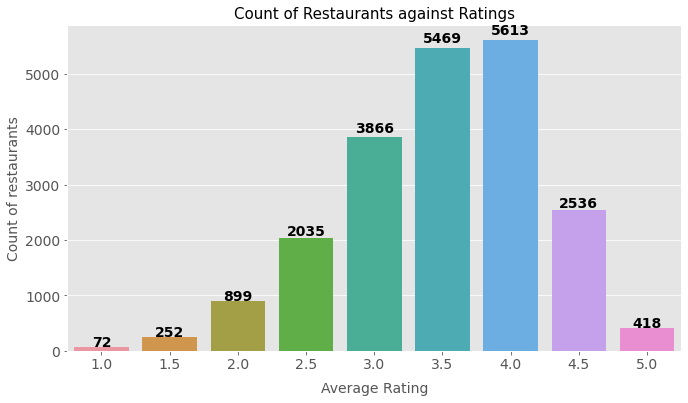

In [38]:
## Ratings Distribution

## Distribution of ratings by restaurants

plt.figure(figsize=(11,6))
grouped = us_restaurants.stars.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values)
plt.xlabel('Average Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of restaurants', fontsize=14)
plt.title('Count of Restaurants against Ratings', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

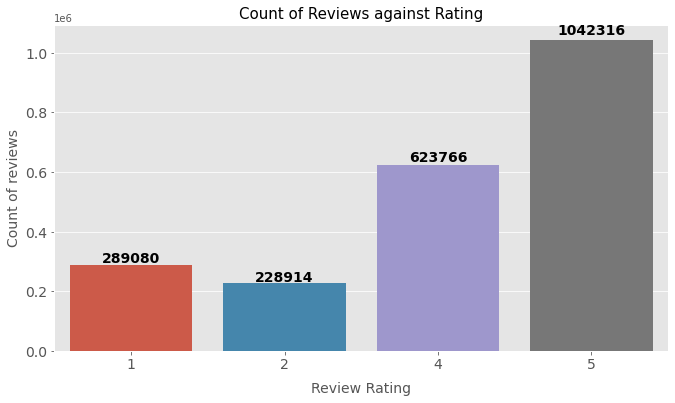

In [39]:
## Distribution of ratings by reviews

plt.figure(figsize=(11,6))
grouped = restaurants_reviews.review_star.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values)
plt.xlabel('Review Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews against Rating', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

In [0]:
## Review Analysis

### Positive words and negative words

import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [0]:
## convert text to lower case
restaurants_reviews.text = restaurants_reviews.text.str.lower()

## remove unnecessary punctuation
restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')

In [0]:
## import positive file which contains common meaningless positive words such as good
file_positive = open('/content/drive/My Drive/positive.txt')
reader =csv.reader(file_positive)
positive_words = [word[0] for word in reader]

## import negative file which contains common meaningless positive words such as bad
file_negative = open('/content/drive/My Drive/negative.txt', encoding="ISO-8859-1")
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]

In [0]:
## get dataset by category
def get_dataset(category):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df

## only keep positive and negative words
def filter_words(review, positive_words = positive_words, negative_words = negative_words):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words

In [0]:
## Use American For example
Indian_reviews = get_dataset('Indian')

In [45]:
Indian_reviews

,text,labels
0,today for lunch i picked biryani chicken and v...,positive
1,oh my goodness this is a hidden gem we ordered...,positive
2,this neighborhood bistro could just as easily ...,positive
3,2nd time here and will definitely be back for ...,positive
4,went for lunch a week ago and was super impres...,positive
...,...,...
43711,amazing food buffet was fresh full of options ...,positive
43712,we went on sunday for the buffet it was really...,positive
43713,food is good people are nice they cook everyth...,positive
43714,consistently good food here the tandoori chick...,positive


In [46]:
Indian_train, Indian_test = train_test_split(Indian_reviews[['text','labels']],test_size=0.5)
print('Total %d number of reviews' % Indian_train.shape[0])

Total 21858 number of reviews


In [0]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

In [0]:
## filter words
Indian_train.text = Indian_train.text.apply(filter_words)

In [0]:
## construct features and labels
terms_train=list(Indian_train['text'])
class_train=list(Indian_train['labels'])

terms_test=list(Indian_test['text'])
class_test=list(Indian_test['labels'])

In [50]:
## get bag of words : the frequencies of various words appeared in each review
vectorizer = CountVectorizer()
feature_train_counts=vectorizer.fit_transform(terms_train)
feature_train_counts.shape

(21858, 3015)

In [51]:
## run model
svm = LinearSVC()
svm.fit(feature_train_counts, class_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
# Now we calculate the polarity score

In [0]:
## create dataframe for score of each word in a review calculated by svm model
coeff = svm.coef_[0]
Indian_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})

In [0]:
## get frequency of each word in all reviews in specific category
Indian_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
Indian_reviews['labels'] = class_train
Indian_frequency = Indian_reviews[Indian_reviews['labels'] =='positive'].sum()[:-1]

In [0]:
Indian_words_score.set_index('word', inplace=True)

In [0]:
Indian_polarity_score = Indian_words_score
Indian_polarity_score['frequency'] = Indian_frequency

In [0]:
## calculate polarity score 
Indian_polarity_score['polarity'] = Indian_polarity_score.score * Indian_polarity_score.frequency / Indian_reviews.shape[0]

In [0]:
## drop unnecessary words
unuseful_positive_words = Indian_polarity_score.loc[['great','amazing','love','best','awesome','excellent','good',
                                                    'favorite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous']]
unuseful_negative_words =  Indian_polarity_score.loc[['bad','disappointed','unfortunately','disappointing','horrible',
                                                     'lacking','terrible','sorry', 'disappoint']]

Indian_polarity_score.drop(unuseful_positive_words.index, axis=0, inplace=True)
Indian_polarity_score.drop(unuseful_negative_words.index, axis=0, inplace=True)

In [0]:
Indian_polarity_score.polarity = Indian_polarity_score.polarity.astype(float)
Indian_polarity_score.frequency = Indian_polarity_score.frequency.astype(float)

In [60]:
Indian_polarity_score[Indian_polarity_score.polarity>0].sort_values('polarity', ascending=False)[:20]

,score,frequency,polarity
word,,,
delicious,0.7092,4499.0000,0.1460
friendly,0.2273,2813.0000,0.0292
fresh,0.1942,2198.0000,0.0195
recommend,0.1433,2129.0000,0.0140
attentive,0.3029,893.0000,0.0124
authentic,0.1842,1468.0000,0.0124
pleasantly,1.2772,194.0000,0.0113
reasonable,0.3586,643.0000,0.0105
outstanding,0.5619,380.0000,0.0098


In [61]:
Indian_polarity_score[Indian_polarity_score.polarity<0].sort_values('polarity', ascending=True)[:20]

,score,frequency,polarity
word,,,
bland,-0.8258,121.0000,-0.0046
cold,-0.5002,199.0000,-0.0046
work,-0.2088,468.0000,-0.0045
expensive,-0.3160,257.0000,-0.0037
wrong,-0.2628,296.0000,-0.0036
warm,-0.1575,487.0000,-0.0035
sweet,-0.0863,730.0000,-0.0029
hard,-0.1361,448.0000,-0.0028
seasoned,-0.2114,266.0000,-0.0026


Get top 10 most informative positive and negative words

In [0]:

Indian_top_positive_words = ['delicious','friendly','fresh','attentive','authentic','outstanding','perfection','tender','reasonable','pleasantly']
Indian_top_negative_words = ['bland','expensive','cold','sweet', 'hard', 'slow','limited','frozen','greasy','overpriced']
Indian_top_words = Indian_polarity_score.loc[Indian_top_positive_words+Indian_top_negative_words,'polarity']

(array([-0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,
         0.16]), <a list of 10 Text major ticklabel objects>)

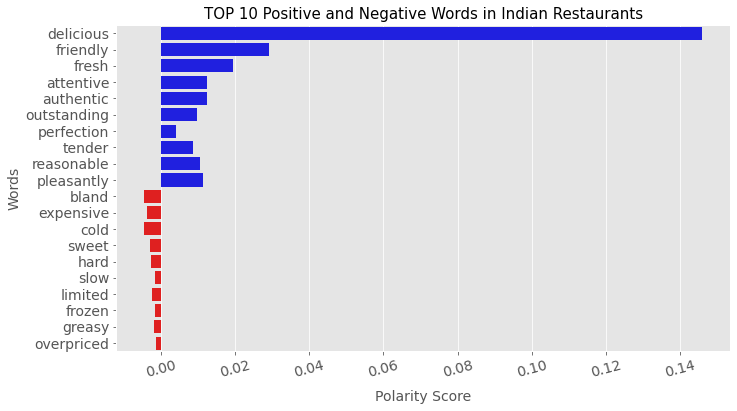

In [63]:
plt.figure(figsize=(11,6))
colors = ['red' if c < 0 else 'blue' for c in Indian_top_words.values]
sns.barplot(y=Indian_top_words.index, x=Indian_top_words.values, palette=colors)
plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('TOP 10 Positive and Negative Words in Indian Restaurants', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)